In [ ]:
pip install torch torchvision torchaudio


In [2]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Define paths (update if needed)
dir1 = "/content/drive/MyDrive/proj/First Print"  # Original QR codes
dir2 = "/content/drive/MyDrive/proj/Second Print"  # Counterfeit QR codes



## visual inspection


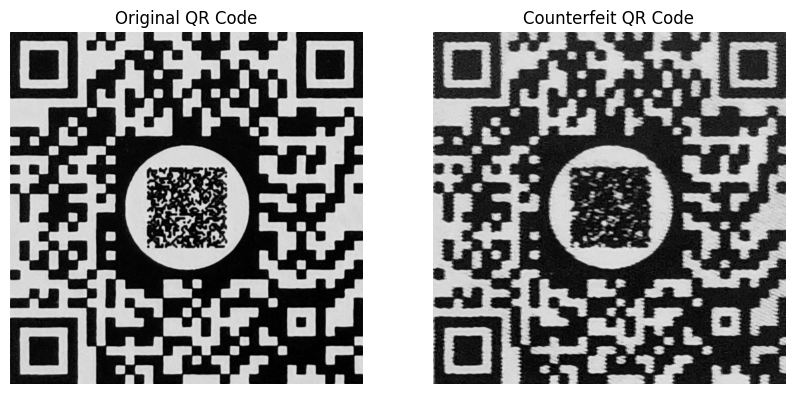

In [3]:
original_img_path = os.path.join(dir1, sorted(os.listdir(dir1))[0])
counterfeit_img_path = os.path.join(dir2, sorted(os.listdir(dir2))[0])

original_img = cv2.imread(original_img_path, cv2.IMREAD_GRAYSCALE)
counterfeit_img = cv2.imread(counterfeit_img_path, cv2.IMREAD_GRAYSCALE)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(original_img, cmap='gray')
ax[0].set_title("Original QR Code")
ax[0].axis("off")

ax[1].imshow(counterfeit_img, cmap='gray')
ax[1].set_title("Counterfeit QR Code")
ax[1].axis("off")

plt.show()

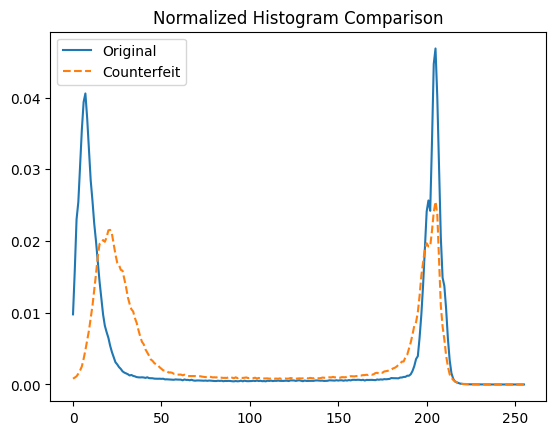

In [4]:
gray_original = original_img.copy()
gray_counterfeit = counterfeit_img.copy()

# Compute histograms
hist_original = cv2.calcHist([gray_original], [0], None, [256], [0, 256])
hist_original = hist_original / np.sum(hist_original)  # normalize

hist_counterfeit = cv2.calcHist([gray_counterfeit], [0], None, [256], [0, 256])
hist_counterfeit = hist_counterfeit / np.sum(hist_counterfeit)  # normalize

# Plot both histograms
plt.plot(hist_original, label="Original")
plt.plot(hist_counterfeit, label="Counterfeit", linestyle='dashed')
plt.title("Normalized Histogram Comparison")
plt.legend()
plt.show()


In [5]:
hist_original.max()

np.float32(0.04684708)

In [6]:
# Compute Sobel gradients
sobel_x = cv2.Sobel(original_img, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(original_img, cv2.CV_64F, 0, 1, ksize=3)
sobel_magnitude_original = np.sqrt(sobel_x**2 + sobel_y**2).sum()

sobel_x = cv2.Sobel(counterfeit_img, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(counterfeit_img, cv2.CV_64F, 0, 1, ksize=3)
sobel_magnitude_counterfeit = np.sqrt(sobel_x**2 + sobel_y**2).sum()

print(f"Sobel Edge Strength - Original: {sobel_magnitude_original}")
print(f"Sobel Edge Strength - Counterfeit: {sobel_magnitude_counterfeit}")


Sobel Edge Strength - Original: 53306467.79460102
Sobel Edge Strength - Counterfeit: 50206413.42078563


In [7]:
sobel_magnitude_counterfeit/sobel_magnitude_original

np.float64(0.9418446859814378)

### QR code feature extraction and classification

Using Resnet50 for feature extraction and visualising embedded features

In [8]:
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def get_embedding(image):
    image = Image.fromarray(image)
    image = image.convert("RGB")
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        embedding = model(image)
    return embedding.squeeze().numpy()


# Extract embeddings
embedding_original = get_embedding(original_img)
embedding_counterfeit = get_embedding(counterfeit_img)

print("Embedding Shape:", embedding_original.shape)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 77.2MB/s]


Embedding Shape: (2048,)


In [9]:

def load_images(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        images.append(img)

    return (images)

# Load embeddings
original = load_images(dir1)
counterfeit = load_images(dir2)



In [10]:
def get_all_embeddings(images):
    embeddings = []
    for img in images:
        emb = get_embedding(img)
        embeddings.append(emb)
    return np.array(embeddings)

original_embeddings = get_all_embeddings(original)
counterfeit_embeddings = get_all_embeddings(counterfeit)


In [11]:
X = np.vstack([original_embeddings, counterfeit_embeddings])
y = np.array([0] * len(original_embeddings) + [1] * len(counterfeit_embeddings))

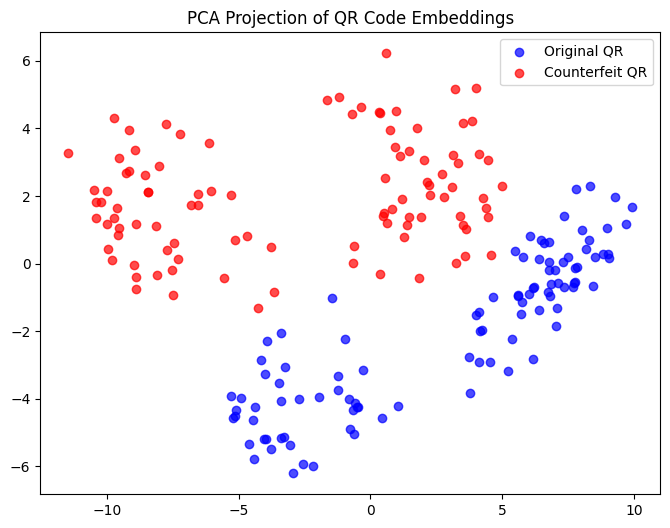

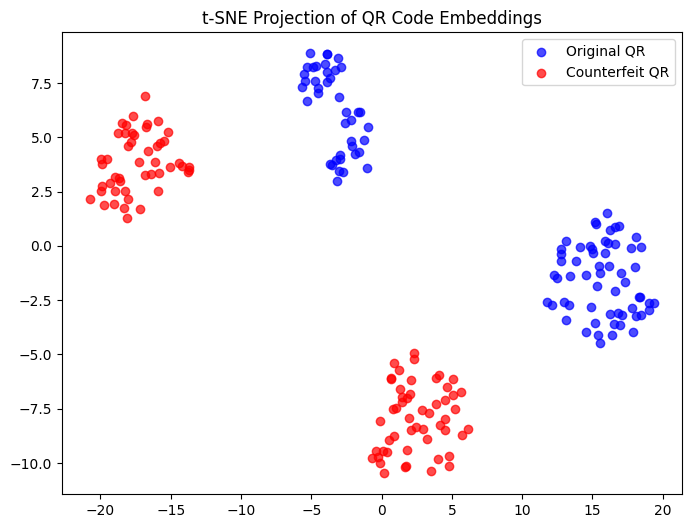

In [12]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Reduce dimensions using t-SNE (for better separation)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

# Plot PCA Projection
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], c='blue', label="Original QR", alpha=0.7)
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], c='red', label="Counterfeit QR", alpha=0.7)
plt.legend()
plt.title("PCA Projection of QR Code Embeddings")
plt.show()

# Plot t-SNE Projection
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[y == 0, 0], X_tsne[y == 0, 1], c='blue', label="Original QR", alpha=0.7)
plt.scatter(X_tsne[y == 1, 0], X_tsne[y == 1, 1], c='red', label="Counterfeit QR", alpha=0.7)
plt.legend()
plt.title("t-SNE Projection of QR Code Embeddings")
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


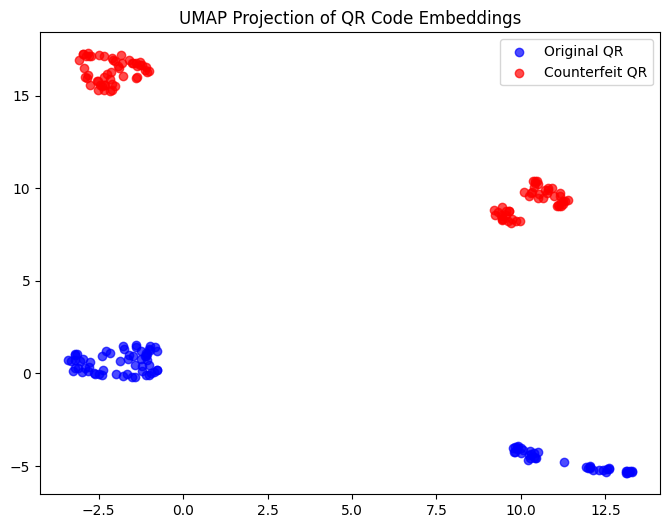

In [13]:
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
X_umap = umap_model.fit_transform(X)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[y==0, 0], X_umap[y==0, 1], color='blue', label="Original QR", alpha=0.7)
plt.scatter(X_umap[y==1, 0], X_umap[y==1, 1], color='red', label="Counterfeit QR", alpha=0.7)
plt.legend()
plt.title("UMAP Projection of QR Code Embeddings")
plt.show()


## fitting a SVM model on feature extracted using Resnet50

In [14]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)



accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


Training CNN model on images for classification

In [15]:

def transform_images(images):
  return_image=[]
  for img in images:
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    return_image.append(img)
  return return_image



# Load data
original_images= transform_images(original)
counterfeit_images= transform_images(counterfeit)

X = np.array(original_images + counterfeit_images).reshape(-1, 128, 128, 1)  # Add channel dimension

# Split into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define CNN model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),

    keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=16)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 578ms/step - accuracy: 0.5457 - loss: 0.6785 - val_accuracy: 0.5250 - val_loss: 0.6589
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 628ms/step - accuracy: 0.6518 - loss: 0.6331 - val_accuracy: 0.9250 - val_loss: 0.4590
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 556ms/step - accuracy: 0.7742 - loss: 0.4781 - val_accuracy: 0.7250 - val_loss: 0.4368
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 475ms/step - accuracy: 0.8930 - loss: 0.3318 - val_accuracy: 0.9500 - val_loss: 0.1659
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 716ms/step - accuracy: 0.9473 - loss: 0.2000 - val_accuracy: 1.0000 - val_loss: 0.0722
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 781ms/step - accuracy: 0.9555 - loss: 0.1410 - val_accuracy: 1.0000 - val_loss: 0.0453
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 668ms/step - accuracy: 1.0000 - loss: 0.0313 - val_accuracy: 1.0000 - val_loss: 0.0401
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 471ms/step - accuracy: 0.9676 - loss: 0.0992 - val_accuracy: 1